### Developing LLM Powered Simple Chatbot using LangGraph
##### Simple Graph using LangGraph Workflow (LLM)
* 1) Nodes --> Python functions --> task 
* 2) Edges --> Connect the nodes using conditional edges 
* 3) State --> State Schema serves as the input for all nodes and edges 
* 4) StateGraph --> Structure of the entire graph 

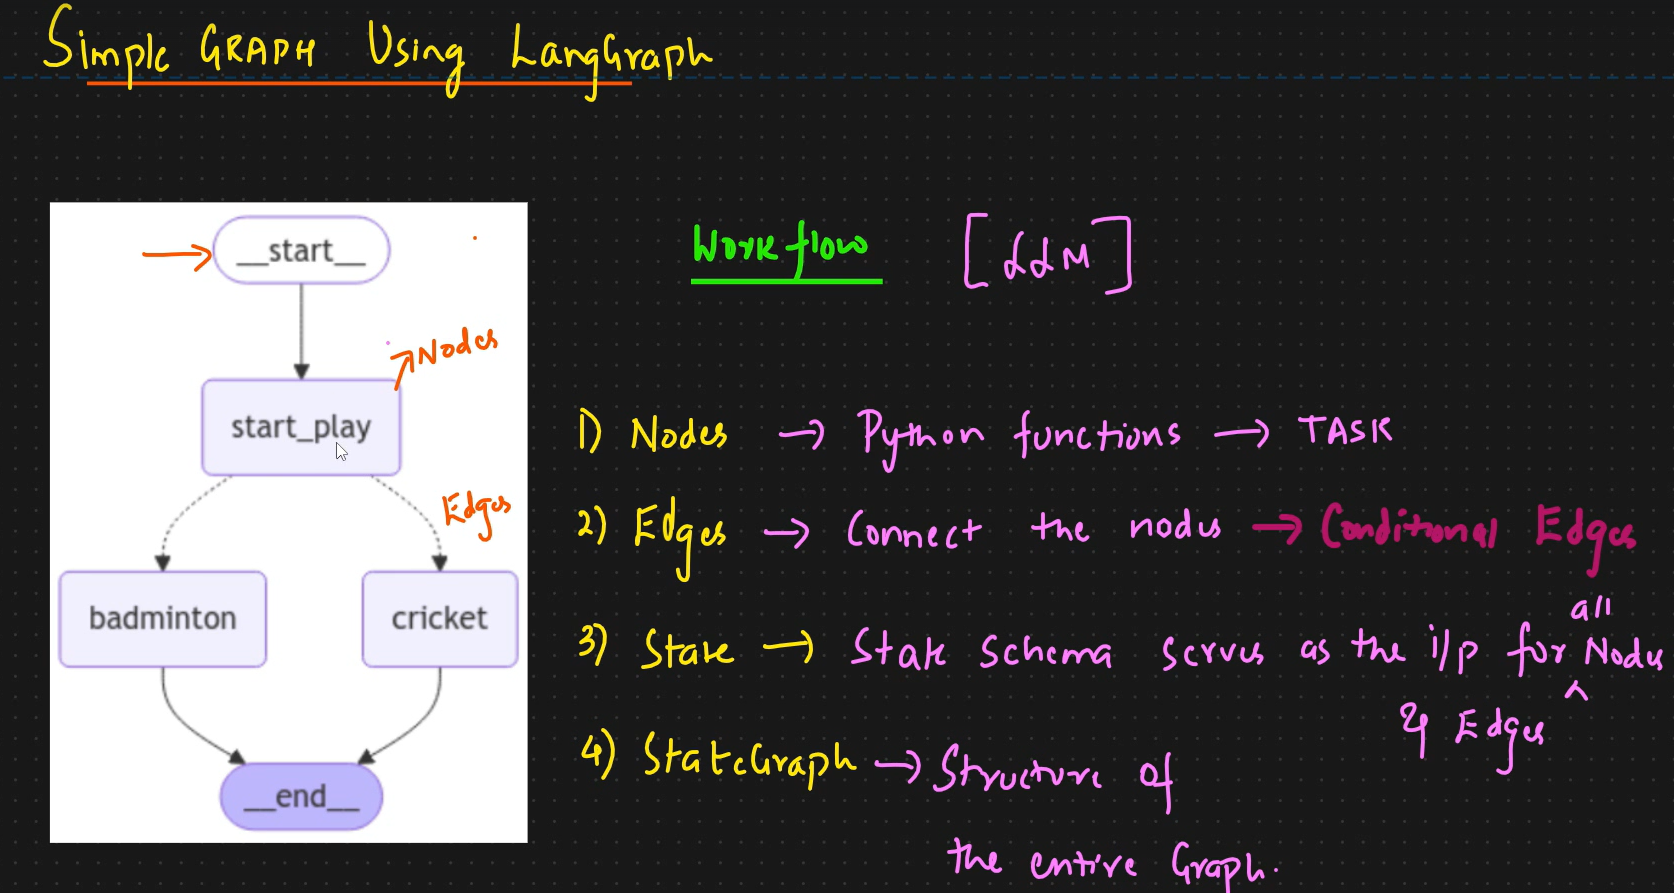

### A Simple Chatbot with LangGraph called "SuperBot". 
##### This SuperBot takes users input and respond to specific input and end the entire graph.
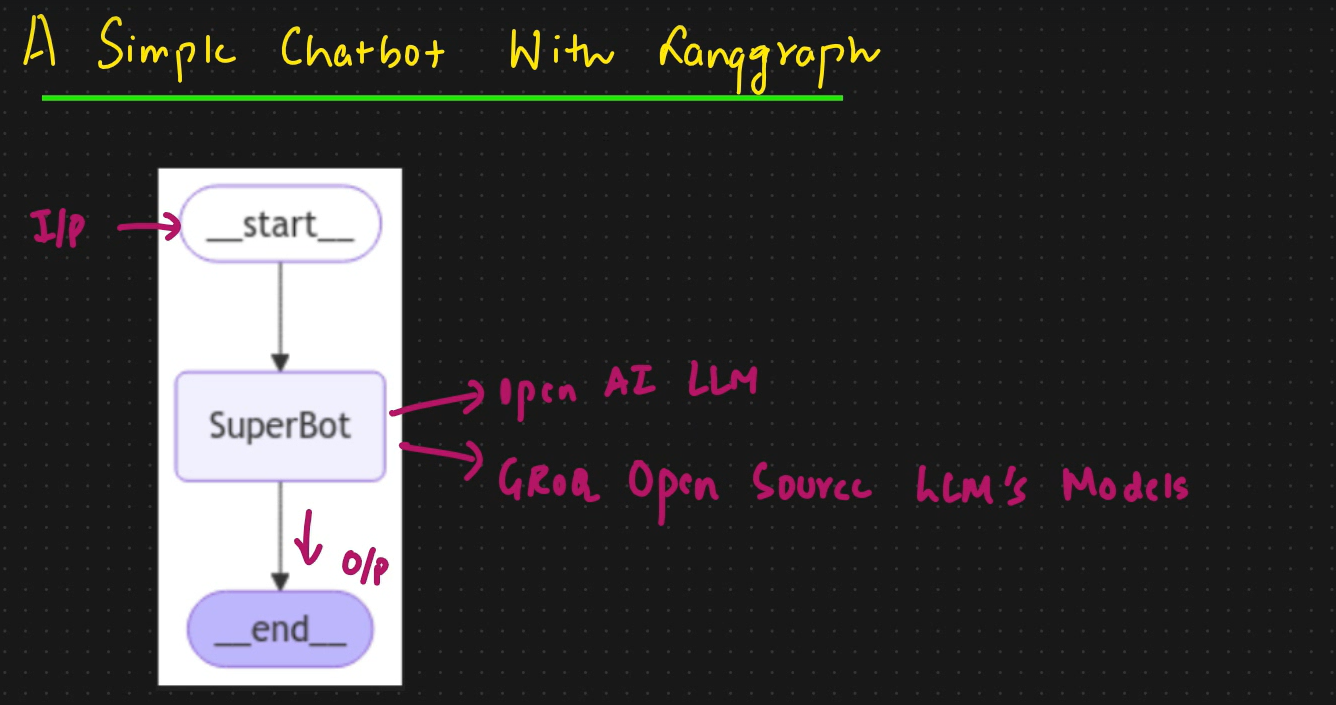
![image-2.png](attachment:image-2.png)

In [ ]:
### Implementing a Simple Chatbot using LangGraph

from typing_extensions import TypedDict 
from langgraph.graph import StateGraph,START,END #StateGraph defines the entire structure of the Graph 

## Reducers 
from typing import Annotated  # Add context-specific metadata to a type.
from langgraph.graph.message import add_messages  


In [11]:
class State(TypedDict):  # State returns the list of  messages like a dict {messages:[msg1,msg2,msg3,...]}
    messages:Annotated[list,add_messages]


In [3]:
# load environment variables 
import os 
from dotenv import load_dotenv
load_dotenv() 

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [6]:
### Define LLM using OPENAI

from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o-mini")
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'id': 'chatcmpl-CscaL39v7bkrNsfnNLjTFfgM3Bh4X', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b7165-fdd8-7430-b8df-c958beff2256-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [9]:
### Define LLM using GROQ
from langchain_groq import ChatGroq
llm_groq=ChatGroq(model="qwen/qwen3-32b")
llm_groq.invoke("Hi,I'm Venkat and like to play Badminton")

AIMessage(content="<think>\nOkay, the user is Venkat and he likes to play badminton. I need to respond appropriately. First, I should acknowledge his introduction and express enthusiasm about his interest in badminton. Maybe ask how long he's been playing or if he has a favorite type of game, like singles or doubles. Also, offer to share some tips or talk about strategies. I should keep the tone friendly and encouraging. Let me make sure the response is welcoming and invites further conversation. Avoid any technical jargon unless he asks for it. Keep it simple and engaging.\n</think>\n\nHi Venkat! Welcome! It's great to hear you enjoy playing badminton—it's such an exciting and fast-paced sport! 🎾 Do you play mostly singles or doubles? I’d love to know what you enjoy most about the game or if you have any favorite strategies. If you ever want tips, drills, or just to chat about rallies, feel free to ask! 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 

### We will start with creating nodes

In [17]:
def superbot(state:State):
    return {"messages":[llm_groq.invoke(state['messages'])]}

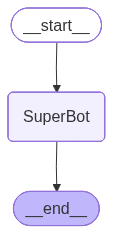

In [19]:
### Crate graph 
graph = StateGraph(State)

# create superbot node
graph.add_node("SuperBot",superbot)

# create the edge from START to superbot 
graph.add_edge(START,"SuperBot")

# create the edge from SuperBot to END
graph.add_edge("SuperBot",END)

# compile the graph 
graph_builder=graph.compile()

# view/display the graph 
from IPython.display import Image,display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

### Executing the graph
#### 1. Invocation 

In [ ]:
## Execute this graph in 2 ways: 1)Invocation   2)Steaming
# 1. Invocation 
graph_builder.invoke({'messages':"Hi,my name is Venkat and I like badminton"})
# this must give HumanMessage and AIMessage. messages getting appended here. If we dont use the reducer, messages wont append.


{'messages': [HumanMessage(content='Hi,my name is Venkat and I like badminton', additional_kwargs={}, response_metadata={}, id='75adff06-4cb7-4987-a51c-db2953333489'),
  AIMessage(content="<think>\nOkay, the user introduced himself as Venkat and mentioned that he likes badminton. I should respond in a friendly and welcoming way. Let me start by greeting him and acknowledging his interest in badminton.\n\nI wonder if he plays often or if he's looking to improve his skills. Maybe I can ask him some questions to learn more and offer helpful suggestions. Badminton is a great sport; it's fun and good exercise. I should keep the tone positive and engaging.\n\nI need to make sure my response is encouraging and open-ended so he feels comfortable to share more. Perhaps I can mention different aspects of the game, like playing with friends or fitness benefits. Also, maybe he's interested in tips or local badminton events. I should avoid making assumptions but leave the door open for him to elabo

### 2. Streaming the responses

In [21]:
graph_builder.stream({"messages":"Hello,My name is Venkat"})

<generator object Pregel.stream at 0x0000023D6F36B0D0>

In [ ]:
for event in graph_builder.stream({"messages":"Hello,My name is Venkat"}):
    print(event)
#Here, we only get the latest message when we stream.

{'SuperBot': {'messages': [AIMessage(content="<think>\nOkay, the user introduced himself as Venkat. I need to respond in a friendly and welcoming manner. Since he didn't ask a question, maybe I should offer help with anything he might need. Keep it open-ended but not too pushy. Also, note his name and use it in the response to build a connection. Let me check if there are any cultural considerations for Venkat. Venkat is a common Indian name, so maybe a slight nod to that with a smiley or something. No, better to keep it neutral. Just a simple greeting, acknowledgment of his name, and offer assistance. Make sure the tone is positive and approachable.\n</think>\n\nHello, Venkat! 😊 Nice to meet you! How can I assist you today? Whether you have questions or just want to chat, I'm here for you.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 173, 'prompt_tokens': 15, 'total_tokens': 188, 'completion_time': 0.433893649, 'completion_tokens_details': None, 'pro

In [28]:
## Passing stream_mode="values". With this mode, message will get appended to the list of messages.
#Here, we will get both the HumanMessage and AIMessage.

for event in graph_builder.stream({"messages":"Hello,My name is Venkat"},stream_mode="values"):
    print(event)


{'messages': [HumanMessage(content='Hello,My name is Venkat', additional_kwargs={}, response_metadata={}, id='eb4594fc-abc4-4372-8d11-1efabd6cebc1')]}
{'messages': [HumanMessage(content='Hello,My name is Venkat', additional_kwargs={}, response_metadata={}, id='eb4594fc-abc4-4372-8d11-1efabd6cebc1'), AIMessage(content="<think>\nOkay, the user introduced themselves as Venkat. I should acknowledge their greeting and respond in a friendly manner. Keep it simple and open-ended to encourage further conversation.\n\nLet me make sure the response is warm and welcoming. Maybe add a slight smiley to keep it approachable. I'll keep the tone positive and open for them to share more if they'd like.\n</think>\n\nHello, Venkat! 😊 Nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 15, 'total_tokens': 113, 'completion_time': 0.226119424, 'completion_tokens_details': None, 'prompt_time': 0.000427972, 'prompt_

In [30]:
## Passing stream_mode="updates". With this mode, message will not get appended to the list of messages.
#Here, we will get both the HumanMessage and AIMessage.

for event in graph_builder.stream({"messages":"Hello,My name is Venkat"},stream_mode="updates"): # Default stream_mode is "updates"
    print(event)

{'SuperBot': {'messages': [AIMessage(content="<think>\nOkay, the user introduced himself as Venkat. I should respond in a friendly and welcoming manner. Let me make sure to acknowledge his introduction and offer assistance. I'll keep it simple and open-ended so he feels comfortable asking for help with whatever he needs.\n</think>\n\nHello, Venkat! Nice to meet you. How can I assist you today? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 15, 'total_tokens': 91, 'completion_time': 0.152414054, 'completion_tokens_details': None, 'prompt_time': 0.000407778, 'prompt_tokens_details': None, 'queue_time': 0.10054458, 'total_time': 0.152821832}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_efa9879028', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b717d-4fa4-7891-9d5d-499df20094b8-0', usage_metadata={'input_tokens': 15, 'output_tokens': 76, 'total_tokens': 